# TẠO ẢNH TỪ CSV

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageFilter

# ⚙️ Cấu hình
csv_path = 'fer2013.csv'
output_dir = 'FER2013_Images'

# Nhãn tương ứng với emotion
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# 📥 Đọc file CSV
df = pd.read_csv(csv_path)

# 📂 Tạo thư mục output nếu chưa có
for usage in df['Usage'].unique():
    for label in emotion_labels.values():
        os.makedirs(os.path.join(output_dir, usage, label), exist_ok=True)

# 🔄 Duyệt từng dòng và lưu ảnh
for i, row in df.iterrows():
    emotion = int(row['emotion'])
    pixels = list(map(int, row['pixels'].split()))
    usage = row['Usage']  # Training, PublicTest, PrivateTest

    # Chuyển thành ảnh 48x48
    image = np.array(pixels, dtype=np.uint8).reshape(48, 48)
    img = Image.fromarray(image)
    img = img.convert("RGB")  # để dùng ResNet cần ảnh RGB

    # Resize ảnh lên 224x224
    img_resized = img.resize((224, 224), resample=Image.BICUBIC)

    # Làm nét ảnh (Sharpening)
    sharpener = ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)
    img_sharpened = img_resized.filter(sharpener)

    # Tên file ảnh
    label_name = emotion_labels[emotion]
    file_name = f"{i}.jpg"
    save_path = os.path.join(output_dir, usage, label_name, file_name)

    img_sharpened.save(save_path)

print("✅ Hoàn tất tạo ảnh từ CSV, resize ảnh lên 224x224 và làm nét ảnh!")


✅ Hoàn tất tạo ảnh từ CSV, resize ảnh lên 224x224 và làm nét ảnh!


In [20]:
import os

# Cấu hình
output_dir = 'FER2013_Images'

# Nhãn tương ứng với emotion
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# 📂 Đếm số ảnh theo từng Usage (Training, PublicTest, PrivateTest) và từng emotion
image_counts = {}

for usage in os.listdir(output_dir):  # Duyệt qua các thư mục (Training, PublicTest, PrivateTest)
    if os.path.isdir(os.path.join(output_dir, usage)):  # Kiểm tra nếu là thư mục
        image_counts[usage] = {}
        for label in emotion_labels.values():  # Duyệt qua từng emotion
            folder_path = os.path.join(output_dir, usage, label)
            if os.path.exists(folder_path):  # Kiểm tra nếu thư mục tồn tại
                image_counts[usage][label] = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            else:
                image_counts[usage][label] = 0

# In kết quả đếm số ảnh
for usage, labels in image_counts.items():
    print(f"\n[Usage: {usage}]")
    for label, count in labels.items():
        print(f"{label}: {count} ảnh")




[Usage: AllData]
Angry: 4953 ảnh
Disgust: 547 ảnh
Fear: 5121 ảnh
Happy: 8989 ảnh
Sad: 6077 ảnh
Surprise: 4002 ảnh
Neutral: 6198 ảnh

[Usage: PrivateTest]
Angry: 491 ảnh
Disgust: 55 ảnh
Fear: 528 ảnh
Happy: 879 ảnh
Sad: 594 ảnh
Surprise: 416 ảnh
Neutral: 626 ảnh

[Usage: PublicTest]
Angry: 467 ảnh
Disgust: 56 ảnh
Fear: 496 ảnh
Happy: 895 ảnh
Sad: 653 ảnh
Surprise: 415 ảnh
Neutral: 607 ảnh

[Usage: Training]
Angry: 3995 ảnh
Disgust: 436 ảnh
Fear: 4097 ảnh
Happy: 7215 ảnh
Sad: 4830 ảnh
Surprise: 3171 ảnh
Neutral: 4965 ảnh


# HIỆN THÔNG TIN THƯ MUC

In [14]:
import os

def print_folder_tree(start_path):
    for root, dirs, _ in os.walk(start_path):
        level = root.replace(start_path, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}📁 {os.path.basename(root)}/")

# Gọi hàm
print_folder_tree("FER2013_Images")


📁 FER2013_Images/
    📁 AllData/
        📁 Angry/
        📁 Disgust/
        📁 Fear/
        📁 Happy/
        📁 Neutral/
        📁 Sad/
        📁 Surprise/
    📁 PrivateTest/
        📁 Angry/
        📁 Disgust/
        📁 Fear/
        📁 Happy/
        📁 Neutral/
        📁 Sad/
        📁 Surprise/
    📁 PublicTest/
        📁 Angry/
        📁 Disgust/
        📁 Fear/
        📁 Happy/
        📁 Neutral/
        📁 Sad/
        📁 Surprise/
    📁 Training/
        📁 Angry/
        📁 Disgust/
        📁 Fear/
        📁 Happy/
        📁 Neutral/
        📁 Sad/
        📁 Surprise/


# NHẬN DIỆN  MỘT ẢNH

In [22]:
import torch
from torchvision import models, transforms
from PIL import Image



In [23]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 7)  # FER2013 có 7 lớp

# Nếu bạn có model đã fine-tune trên FER2013, load lại
# model.load_state_dict(torch.load("model_fer18.pth", map_location='cpu'))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [60]:
# Đường dẫn ảnh cần dự đoán
image_path = "FER2013_Images/Training/Neutral/1688.jpg"  # thay bằng ảnh thực tế

# Mở ảnh và tiền xử lý
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # thêm batch dimension

# Dự đoán
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(f"Ảnh: {image_path}")
print(f"Dự đoán: {class_names[predicted_class]}")


Ảnh: FER2013_Images/Training/Neutral/1688.jpg
Dự đoán: Surprise


# ĐÁNH GIÁ MÔ  HÌNH QUA MA TRẬN NHẦM LẪN  , TỈ LỆ ACCURACY 

In [15]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [16]:
# Cấu hình device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Các biến
data_dir = "FER2013_Images/AllData"
batch_size = 32
image_size = 224  # ResNet18 yêu cầu ảnh kích thước tối thiểu 224x224

# Transform: resize + chuyển tensor + normalize theo ImageNet
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for ImageNet
                         [0.229, 0.224, 0.225])  # Std for ImageNet
])

# Tải toàn bộ dữ liệu
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Chia tập thành train và test (ví dụ: 80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Nhãn
class_names = full_dataset.classes


In [17]:
# Load mô hình ResNet18 pre-trained trên ImageNet
model = models.resnet18(pretrained=True)

# Thay đổi lớp cuối cùng để phù hợp với số lớp cảm xúc (7 lớp)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Đưa mô hình lên GPU nếu có
model = model.to(device)


c:\Users\ADMIN\Documents\Đồ án PPNCKH\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\Documents\Đồ án PPNCKH\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def evaluate(model, dataloader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total

    return y_true, y_pred, avg_loss, accuracy


In [22]:
# Dùng loss cross-entropy
criterion = nn.CrossEntropyLoss()

# Đánh giá
y_true, y_pred, avg_loss, acc = evaluate(model, test_loader, criterion)




Loss: 2.1621
Accuracy: 0.1368

Classification Report:
              precision    recall  f1-score   support

       Angry       0.14      0.86      0.23       992
     Disgust       0.02      0.03      0.02       103
        Fear       0.06      0.00      0.00      1048
       Happy       0.19      0.07      0.10      1763
     Neutral       0.00      0.00      0.00      1272
         Sad       0.20      0.00      0.00      1196
    Surprise       0.21      0.00      0.01       804

    accuracy                           0.14      7178
   macro avg       0.12      0.14      0.05      7178
weighted avg       0.13      0.14      0.06      7178



c:\Users\ADMIN\Documents\Đồ án PPNCKH\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\Documents\Đồ án PPNCKH\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\Documents\Đồ án PPNCKH\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

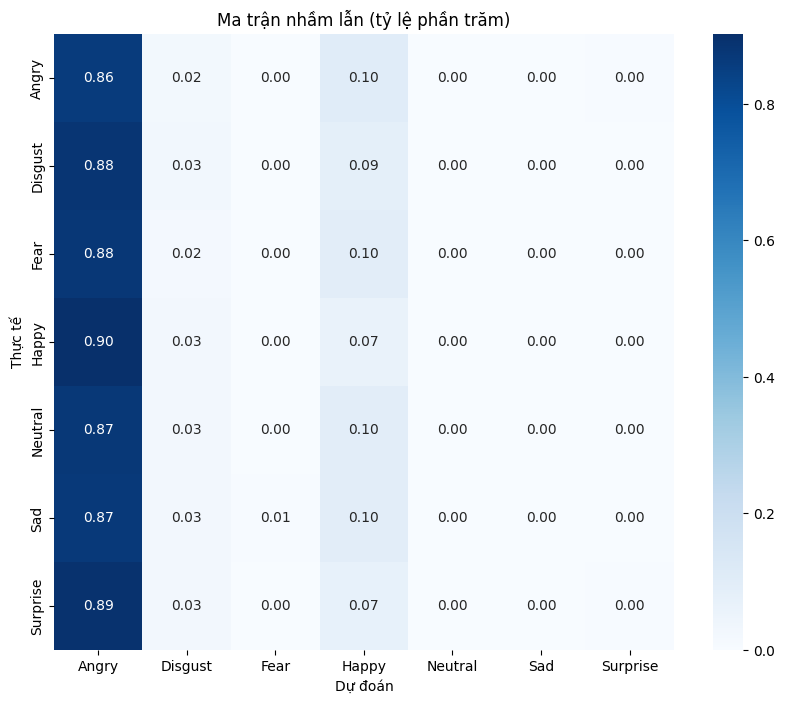

In [23]:
# In kết quả
print(f"Loss: {avg_loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Ma trận nhầm lẫn dạng số
conf_matrix = confusion_matrix(y_true, y_pred)

# Chuẩn hóa theo hàng (tức theo nhãn thực tế)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Vẽ heatmap tỷ lệ
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Ma trận nhầm lẫn (tỷ lệ phần trăm)")
plt.show()